In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Sampler, random_split, Dataset
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd

from collections import defaultdict
from line_profiler import profile
from sklearn.model_selection import train_test_split

import src.data_processing.BruteForceEstimator as bfEstimator
import src.data_processing.ImageCalculations as imgcalc
import src.visualization.BFmethod as graphing
import src.visualization.Metrics as metrics
import src.visualization.ImagePlots as imgplt
import src.data_processing.ImageProducts as ImageProducts
import src.helpers.ModelUtilities as models


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  

/home/jovyan/miniconda3/envs/test/lib/python3.12/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


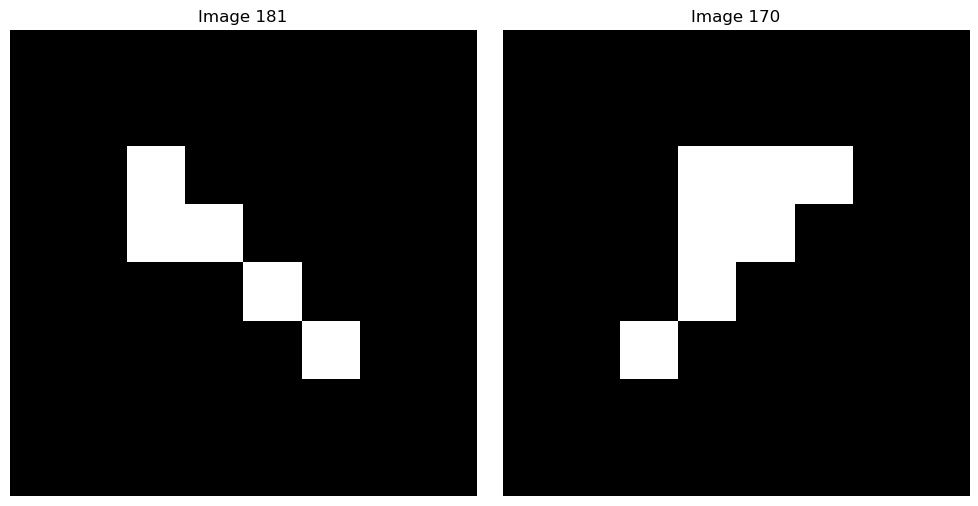

In [2]:
# ----------------------------------Image Input----------------------------------
IMAGE_TYPES = ["NbinMmax_ones", "Nbin", "triangles", "triangle_mean_subtracted"]

IMAGE_FILTERS = ["unique", "Nmax_ones", "one_island"]

IMAGE_PRODUCT_TYPES = ["ncc", "ncc_scaled"]

EMBEDDING_TYPES = ["pencorr_D"]

dimensions = 32

imageType = "triangles"
filters = ["unique"]
imageProductType = "ncc_scaled_-1"
overwrite = {"imgSet": False, "imgProd": False, "embedding": False}
weight = None
embeddingType = f"pencorr_{dimensions}"
k=5

bruteForceEstimator = bfEstimator.BruteForceEstimator(
    imageType=imageType, filters=filters, imageProductType=imageProductType, embeddingType=embeddingType, overwrite=overwrite)

index1 = np.random.randint(len(bruteForceEstimator.imageSet))
index2 = np.random.randint(len(bruteForceEstimator.imageSet))

input1=bruteForceEstimator.imageSet[index1]
input2=bruteForceEstimator.imageSet[index2]

imgplt.plot_original_images(input1, input2, index1, index2)

input_dataset = []
input_images = [input1, input2] 
for i in range(len(input_images)):
    img = np.array(input_images[i], dtype=np.float64)
    img = torch.from_numpy(img)
    img = img.unsqueeze(0).unsqueeze(0).cuda().double()
    input_dataset.append(img)

stacked_tensor = torch.stack(input_dataset)
input_dataset = stacked_tensor.cpu().numpy()      
input_dataset = [torch.tensor(data).cuda().float() for data in input_dataset]

In [3]:
# -----------------------------Evaluating Results-----------------------------
model = models.SimpleCNN().cuda()
model.load_state_dict(torch.load('model/best_model_batch_greyscale_8bin.pt'))
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

#----------------------Metric 1 - Loss Calculation-----------------
scale = ImageProducts.scale_min(ImageProducts.ncc, -1)
NCC_scaled_value = scale(input1,input2)

print("\nLoss Calculation")
print("\nScaled NCC: ",NCC_scaled_value)

embedded_vector_image1 = model(input_dataset[0])
embedded_vector_image2 = model(input_dataset[1])

dot_product_value = torch.sum(embedded_vector_image1 * embedded_vector_image2, dim=1) 

print("Dot product value of model: ", dot_product_value.item())

NCC_scaled_value = torch.tensor(NCC_scaled_value).to(dot_product_value.device).float()
if NCC_scaled_value.ndim == 0:
    NCC_scaled_value = NCC_scaled_value.unsqueeze(0)

train_loss_value = models.loss_fn_frobenius(dot_product_value, NCC_scaled_value) 
print("Loss: ", train_loss_value.item())

matrixA = bruteForceEstimator.matrixA
matrixG = bruteForceEstimator.matrixG
dot_product_matrix = np.dot(matrixA.T, matrixA)
dot_product_value_Pencorr = dot_product_matrix[index1][index2]
difference = abs(dot_product_value_Pencorr - dot_product_value)

print("\nDot product value of BF Method: ", dot_product_value_Pencorr)
print("Difference in values of BF Method and Model Method: ", difference.item())


Loss Calculation

Scaled NCC:  0.014185190200805664


/tmp/ipykernel_27344/2309580364.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/best_model_batch_greyscale_8bin.pt'))


Dot product value of model:  -0.40566331148147583
Loss:  0.4198485016822815

Dot product value of BF Method:  0.024273956695438664
Difference in values of BF Method and Model Method:  0.4299372732639313



Brute Force Method -- KNN-IOU score
embProd_max_index:  [182 157  88 174  67 181]
imgProd_max_index:  [ 67  72  88  89 157 165 171 172 174 177 181 182 186]

Intersection sets:  [ 67  88 157 174 181 182]
Union sets:  [ 67  72  88  89 157 165 171 172 174 177 181 182 186]
Estimating K-Score for Image 181: K-Score = 0.46153846153846156

Top 13 values of Vector b
Rank 1: Value = 1.0, Index = 181
Rank 2: Value = 0.7888543605804443, Index = 67
Rank 3: Value = 0.7888543605804443, Index = 88
Rank 4: Value = 0.6903085708618164, Index = 182
Rank 5: Value = 0.6000000238418579, Index = 72
Rank 6: Value = 0.6000000238418579, Index = 89
Rank 7: Value = 0.6000000238418579, Index = 157
Rank 8: Value = 0.6000000238418579, Index = 165
Rank 9: Value = 0.6000000238418579, Index = 171
Rank 10: Value = 0.6000000238418579, Index = 172
Rank 11: Value = 0.6000000238418579, Index = 174
Rank 12: Value = 0.6000000238418579, Index = 177
Rank 13: Value = 0.6000000238418579, Index = 186

Top 13 values of Vector c
Ra

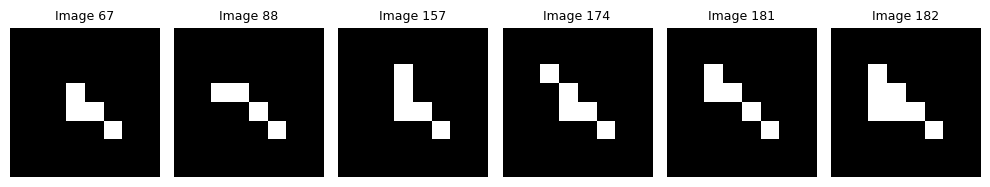


Plotting images in the union set:


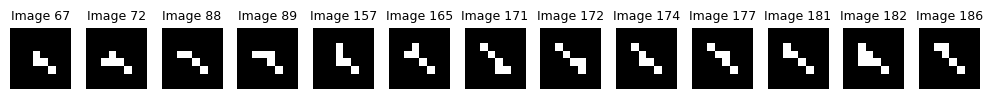


For translationally unique plots: 
Image 67 has no translationally similar images.
Image 72 has no translationally similar images.
Image 88 has no translationally similar images.
Image 89 has no translationally similar images.
Image 157 has no translationally similar images.
Image 165 has no translationally similar images.
Image 171 has no translationally similar images.
Image 172 has no translationally similar images.
Image 174 has no translationally similar images.
Image 177 has no translationally similar images.
Image 181 has no translationally similar images.
Image 182 has no translationally similar images.
Image 186 has no translationally similar images.

Plotting images in the intersection set:


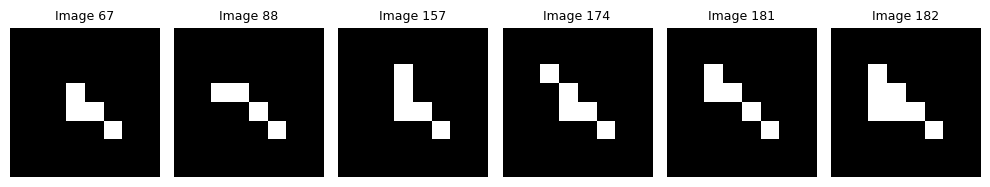


Plotting images in the union set:


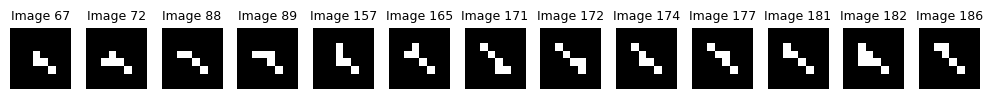

embProd_max_index:  [ 93  92 169 126  77 170]
imgProd_max_index:  [ 77  92  93 126 164 169 170 180]

Intersection sets:  [ 77  92  93 126 169 170]
Union sets:  [ 77  92  93 126 164 169 170 180]
Estimating K-Score for Image 170: K-Score = 0.75

Top 8 values of Vector b
Rank 1: Value = 1.0, Index = 170
Rank 2: Value = 0.8516402244567871, Index = 77
Rank 3: Value = 0.7142858505249023, Index = 92
Rank 4: Value = 0.7142858505249023, Index = 93
Rank 5: Value = 0.7142858505249023, Index = 126
Rank 6: Value = 0.7142858505249023, Index = 164
Rank 7: Value = 0.7142858505249023, Index = 169
Rank 8: Value = 0.7142858505249023, Index = 180

Top 8 values of Vector c
Rank 1: Value = 0.9999999999999998, Index = 170
Rank 2: Value = 0.8656732520623038, Index = 77
Rank 3: Value = 0.8331530740994797, Index = 169
Rank 4: Value = 0.7417583101875044, Index = 126
Rank 5: Value = 0.7057356513887262, Index = 92
Rank 6: Value = 0.6997669935782442, Index = 93
Rank 7: Value = 0.6966058164910961, Index = 180
Rank 8

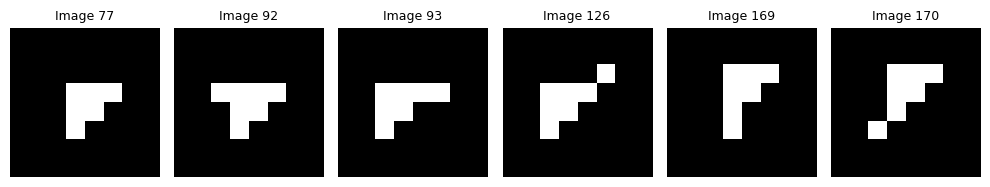


Plotting images in the union set:


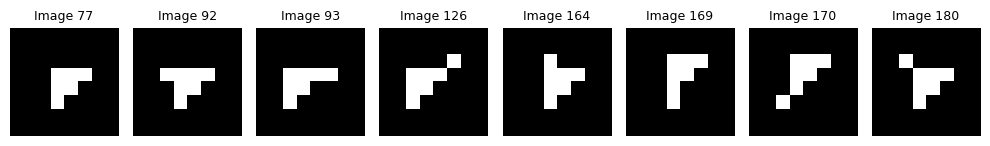


For translationally unique plots: 
Image 77 has no translationally similar images.
Image 92 has no translationally similar images.
Image 93 has no translationally similar images.
Image 126 has no translationally similar images.
Image 164 has no translationally similar images.
Image 169 has no translationally similar images.
Image 170 has no translationally similar images.
Image 180 has no translationally similar images.

Plotting images in the intersection set:


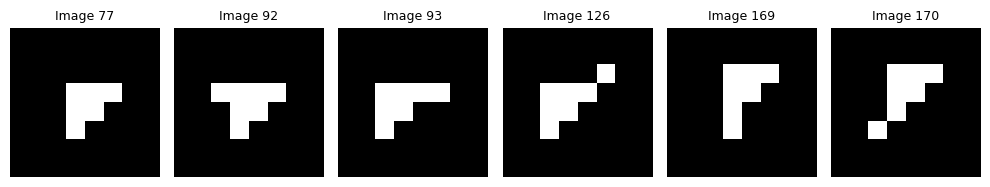


Plotting images in the union set:


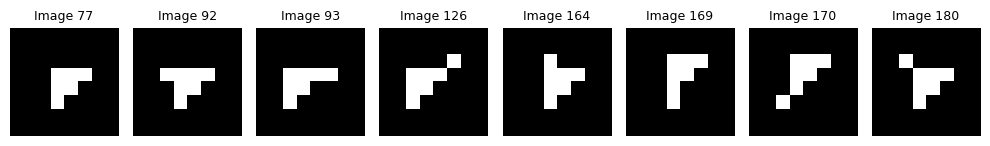


Model Method -- KNN-IOU score
embProd_max_index:  [182 174  88 186 165 181]
imgProd_max_index:  [ 67  72  88  89 157 165 171 172 174 177 181 182 186]

Intersection sets:  [ 88 165 174 181 182 186]
Union sets:  [ 67  72  88  89 157 165 171 172 174 177 181 182 186]
Estimating K-Score for Image 181: K-Score = 0.46153846153846156

Top 13 values of Vector b
Rank 1: Value = 1.0, Index = 181
Rank 2: Value = 0.7888543605804443, Index = 67
Rank 3: Value = 0.7888543605804443, Index = 88
Rank 4: Value = 0.6903085708618164, Index = 182
Rank 5: Value = 0.6000000238418579, Index = 72
Rank 6: Value = 0.6000000238418579, Index = 89
Rank 7: Value = 0.6000000238418579, Index = 157
Rank 8: Value = 0.6000000238418579, Index = 165
Rank 9: Value = 0.6000000238418579, Index = 171
Rank 10: Value = 0.6000000238418579, Index = 172
Rank 11: Value = 0.6000000238418579, Index = 174
Rank 12: Value = 0.6000000238418579, Index = 177
Rank 13: Value = 0.6000000238418579, Index = 186

Top 13 values of Vector c
Rank 1: 

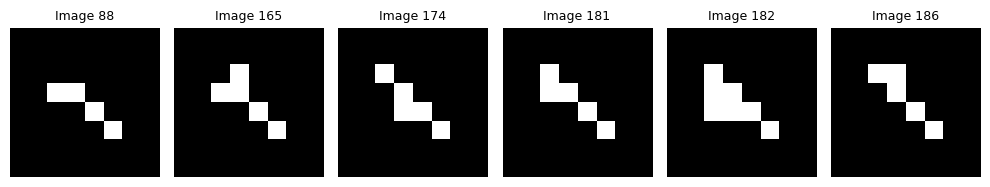


Plotting images in the union set:


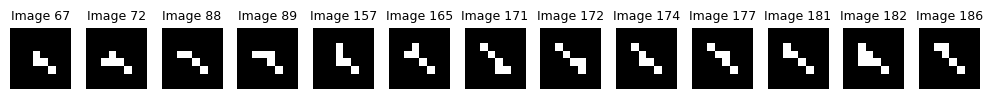


For translationally unique plots: 
Image 67 has no translationally similar images.
Image 72 has no translationally similar images.
Image 88 has no translationally similar images.
Image 89 has no translationally similar images.
Image 157 has no translationally similar images.
Image 165 has no translationally similar images.
Image 171 has no translationally similar images.
Image 172 has no translationally similar images.
Image 174 has no translationally similar images.
Image 177 has no translationally similar images.
Image 181 has no translationally similar images.
Image 182 has no translationally similar images.
Image 186 has no translationally similar images.

Plotting images in the intersection set:


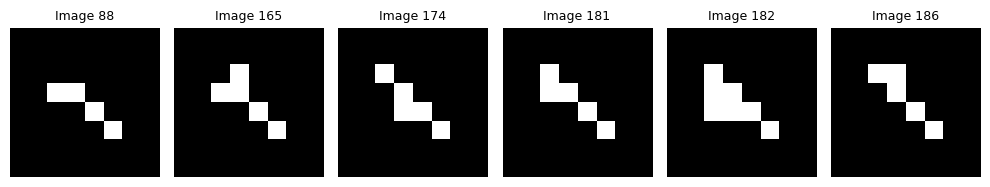


Plotting images in the union set:


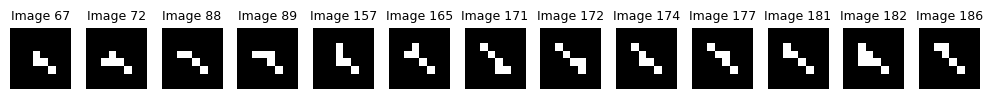

embProd_max_index:  [126 163 169 122 170 191]
imgProd_max_index:  [ 77  92  93 126 164 169 170 180]

Intersection sets:  [126 169 170]
Union sets:  [ 77  92  93 122 126 163 164 169 170 180 191]
Estimating K-Score for Image 170: K-Score = 0.2727272727272727

Top 11 values of Vector b
Rank 1: Value = 1.0, Index = 170
Rank 2: Value = 0.8516402244567871, Index = 77
Rank 3: Value = 0.7142858505249023, Index = 92
Rank 4: Value = 0.7142858505249023, Index = 93
Rank 5: Value = 0.7142858505249023, Index = 126
Rank 6: Value = 0.7142858505249023, Index = 164
Rank 7: Value = 0.7142858505249023, Index = 169
Rank 8: Value = 0.7142858505249023, Index = 180
Rank 9: Value = 0.6903085708618164, Index = 122
Rank 10: Value = 0.6903085708618164, Index = 140
Rank 11: Value = 0.6903085708618164, Index = 148

Top 11 values of Vector c
Rank 1: Value = 1.0000001192092896, Index = 170
Rank 2: Value = 0.8284562826156616, Index = 191
Rank 3: Value = 0.7665250897407532, Index = 122
Rank 4: Value = 0.765686392784118

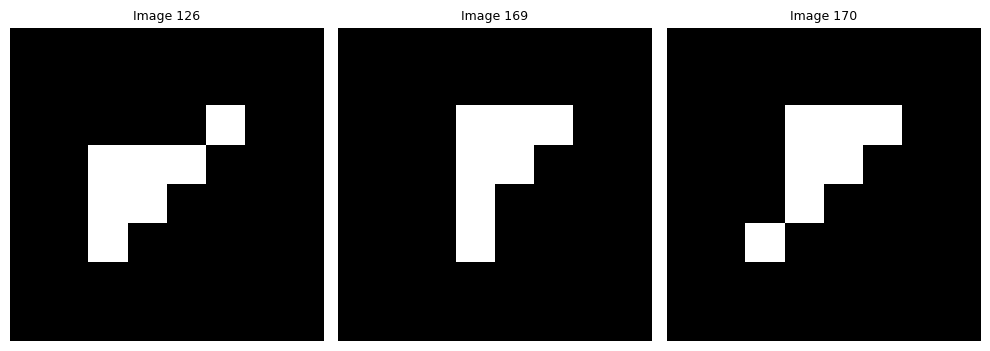


Plotting images in the union set:


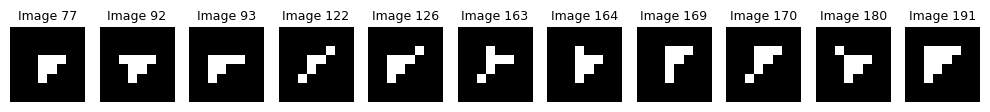


For translationally unique plots: 
Image 77 has no translationally similar images.
Image 92 has no translationally similar images.
Image 93 has no translationally similar images.
Image 122 has no translationally similar images.
Image 126 has no translationally similar images.
Image 163 has no translationally similar images.
Image 164 has no translationally similar images.
Image 169 has no translationally similar images.
Image 170 has no translationally similar images.
Image 180 has no translationally similar images.
Image 191 has no translationally similar images.

Plotting images in the intersection set:


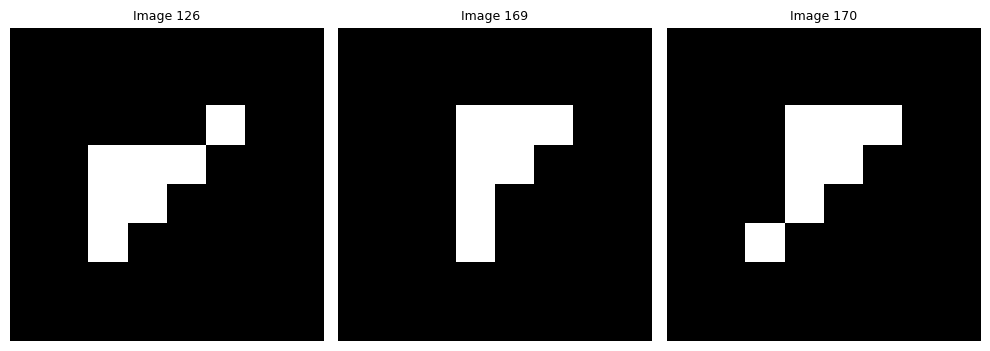


Plotting images in the union set:


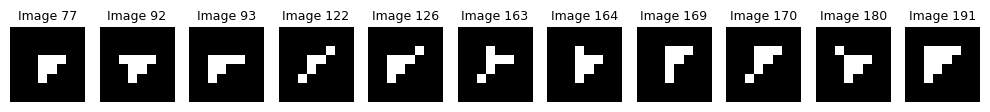

In [4]:
#----------------------Metric 2 - KNNIoU-----------------
print("\nBrute Force Method -- KNN-IOU score")
vectorb_bf1 = bruteForceEstimator.matrixG[index1]
vectorc_bf1 = imgcalc.get_vectorc_brute(index1, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf1, vectorc_bf1, "Brute Force", index1, k, bruteForceEstimator.imageSet)

vectorb_bf2 = bruteForceEstimator.matrixG[index2]
vectorc_bf2 = imgcalc.get_vectorc_brute(index2, bruteForceEstimator.matrixA)
imgplt.display_and_plot_results(vectorb_bf2, vectorc_bf2, "Brute Force", index2, k, bruteForceEstimator.imageSet)

print("\nModel Method -- KNN-IOU score")
input_dataset = []
for img in bruteForceEstimator.imageSet:
    img_tensor = torch.from_numpy(np.array(img, dtype=np.float64))
    img_tensor = img_tensor.unsqueeze(0).unsqueeze(0).cuda().double()
    input_dataset.append(img_tensor)
input_dataset = [tensor.float() for tensor in input_dataset] 

vectorb_model1 = bruteForceEstimator.matrixG[index1]
vectorc_model1 = imgcalc.get_vectorc_model(index1, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model1, vectorc_model1, "Model", index1, k, bruteForceEstimator.imageSet)

vectorb_model2 = bruteForceEstimator.matrixG[index2]
vectorc_model2 = imgcalc.get_vectorc_model(index2, model, input_dataset)
imgplt.display_and_plot_results(vectorb_model2, vectorc_model2, "Model", index2, k, bruteForceEstimator.imageSet)